# Notebook Initialization

In [1]:
# %load nb_init.py

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
config_dir = base_dir / "config"
data_dir = base_dir / "data"
docs_dir = base_dir / "docs"
figures_dir = docs_dir / "figures"
models_dir = base_dir / "models"
logs_dir = base_dir / "logs"
images_input_dir = data_dir / "COVID19"
preprocessed_dir = data_dir / "preprocessed"
output_dir = data_dir / "output"

# Directories used to train the CNN (image by image) 
cnn_data_dir = data_dir / "modelling" / "cnn"
cnn_train_dir = cnn_data_dir / "train"
cnn_test_dir = cnn_data_dir / "test"

metadata_file = images_input_dir / "metadata.csv"
labels_file = images_input_dir / "unzip_filenames.csv"
preprocessed_labels_file = preprocessed_dir / "labels.parquet"

feature_extractor_model_file = models_dir / "feature_extractor.tf"

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

config_file = config_dir / "tfg.conf"

from pyhocon import ConfigFactory
config = None

def load_config():
    return ConfigFactory.parse_file(config_file)

config = load_config()
    
import sys

if str(base_dir / "src") not in sys.path:
    sys.path.append(str(base_dir / "src"))

%load_ext autoreload

%autoreload 2

In [2]:
spark

In [3]:
from tfg import DataRepository

repo = DataRepository(config=config, base_data_path=data_dir)

# Load labels

In [5]:
labels = spark.read.parquet(str(preprocessed_labels_file))

labels.show(5)

+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_clips|
+----------+-------+-------+-----+---------+
|         0|   3131|    285|   CP|        5|
|         0|   3132|     42|   CP|        1|
|         0|   3133|    290|   CP|        5|
|         0|   3134|     37|   CP|        1|
|         0|   3135|    269|   CP|        4|
+----------+-------+-------+-----+---------+
only showing top 5 rows



In [6]:
num_labels = labels.count()
num_labels

4178

In [7]:
labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / num_labels), 4).alias("pct"),
    )\
    .show()

+------+-----+------+
| label|count|   pct|
+------+-----+------+
|    CP| 1556|0.3724|
|   NCP| 1544|0.3696|
|Normal| 1078| 0.258|
+------+-----+------+



In [8]:
labels.select("patient_id").distinct().count()

2742

# Split patient ids into train / test

In [9]:
seed = config.get_int("tfg.seed")
test_fraction = config.get_float("tfg.training.test_fraction")
val_fraction = config.get_float("tfg.training.val_fraction")
train_fraction = 1 - test_fraction - val_fraction
split_weights = [train_fraction, val_fraction, test_fraction]
split_weights

[0.8, 0.1, 0.1]

In [10]:
patient_ids = labels.select("patient_id").distinct()

id_dfs = patient_ids.randomSplit(split_weights, seed=seed)
train_ids = id_dfs[0]
val_ids =  id_dfs[1]
test_ids =  id_dfs[2]

train_labels = labels.join(train_ids, ["patient_id"], "inner")
val_labels = labels.join(val_ids, ["patient_id"], "inner")
test_labels = labels.join(test_ids, ["patient_id"], "inner")

train_count = train_labels.count()
val_count = val_labels.count()
test_count = test_labels.count()

print(f"Training rows: {train_count}")
print(f"Validation rows: {val_count}")
print(f"Test rows: {test_count}")

train_labels.show(5)
val_labels.show(5)
test_labels.show(5)

Training rows: 3350
Validation rows: 402
Test rows: 426
+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_clips|
+----------+-------+-------+-----+---------+
|         0|   3131|    285|   CP|        5|
|         0|   3132|     42|   CP|        1|
|         0|   3133|    290|   CP|        5|
|         0|   3134|     37|   CP|        1|
|         0|   3135|    269|   CP|        4|
+----------+-------+-------+-----+---------+
only showing top 5 rows

+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_clips|
+----------+-------+-------+-----+---------+
|      1075|   3118|    553|   CP|        8|
|      1075|   3119|     70|   CP|        1|
|      1080|   3125|     64|   CP|        1|
|      1093|   3311|    173|   CP|        3|
|      1394|   3847|     62|   CP|        1|
+----------+-------+-------+-----+---------+
only showing top 5 rows

+----------+-------+-------+-----+---------+
|patient_id|scan_id|n_slice|label|num_c

In [11]:
print("Train label counts and percentages")
train_labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / train_count), 2).alias("pct"),
    )\
    .show()

print("Validation label counts and percentages")
val_labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / val_count), 2).alias("pct"),
    )\
    .show()

print("Test label counts and labels")
test_labels\
    .groupBy("label")\
    .agg(
        F.count("*").alias("count"),
        F.round((F.count("*") / test_count), 2).alias("pct"),
    )\
    .show()

Train label counts and percentages
+------+-----+----+
| label|count| pct|
+------+-----+----+
|    CP| 1229|0.37|
|   NCP| 1229|0.37|
|Normal|  892|0.27|
+------+-----+----+

Validation label counts and percentages
+------+-----+----+
| label|count| pct|
+------+-----+----+
|    CP|  152|0.38|
|   NCP|  158|0.39|
|Normal|   92|0.23|
+------+-----+----+

Test label counts and labels
+------+-----+----+
| label|count| pct|
+------+-----+----+
|    CP|  175|0.41|
|   NCP|  157|0.37|
|Normal|   94|0.22|
+------+-----+----+



# Create datasets for the CNN

For each of the train/validation/test sets we have, we will create a pandas dataframe, and we'll use these dataframe to create the data generators for our model.

In [12]:
from dataclasses import dataclass

from pyspark.sql import Row


@dataclass
class Observation:
    patient_id: int
    scan_id: int
    n_slice: int
    num_clips: int
    label: str

    @staticmethod
    def from_row(r: Row) -> "Observation":
        return Observation(
            patient_id=r.patient_id,
            scan_id=r.scan_id,
            n_slice=r.n_slice,
            num_clips=r.num_clips,
            label=r.label,
        )

In [20]:
from tqdm.notebook import tqdm
import pandas as pd
from pathlib import Path

def create_df(config, labels):
    raw_images = {
        "label": [],
        "file": [],
        "patient_id": [],
        "scan_id": [],
        "n_slice": [],
        "num_clips": [],
        "seq_num": [],
        "clip_num": [],
    }

    IMAGES_PER_CLIP = config.get_int("tfg.training.images_per_clip")

    for r in labels.collect():
        obs = Observation.from_row(r)
        scan_path = Path(f"{obs.label}/{obs.patient_id}/{obs.scan_id}")
        absolute_scan_path = images_input_dir / scan_path
        # different directories have different formats
        img_ext = next(absolute_scan_path.glob("*.*")).suffix

        scan_images = []
        seq_nums = []
        clip_nums = []

        seq_num = 0
        images_input_dir_str = str(images_input_dir)
        path_offset = len(images_input_dir_str) + 1
        for seq_num, img in enumerate(absolute_scan_path.glob(f"*{img_ext}")):
            img_to_append = str(img)[path_offset:]
            scan_images.append(img_to_append)
            seq_nums.append(seq_num)
            clip_nums.append(seq_num // IMAGES_PER_CLIP)
            seq_num = seq_num + 1

        raw_images["label"].extend([obs.label] * obs.n_slice)
        raw_images["file"].extend(scan_images)
        raw_images["patient_id"].extend([obs.patient_id] * obs.n_slice)
        raw_images["scan_id"].extend([obs.scan_id] * obs.n_slice)
        raw_images["n_slice"].extend([obs.n_slice] * obs.n_slice)
        raw_images["num_clips"].extend([obs.patient_id] * obs.n_slice)
        raw_images["seq_num"].extend(seq_nums)
        raw_images["clip_num"].extend(clip_nums)
        
    return pd.DataFrame(raw_images)

In [21]:
train_df = create_df(config, train_labels)
print(f"{train_df.shape}")
train_df

(331286, 8)


,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/0/3131/0275.png,0,3131,285,0,0,0
1,CP,CP/0/3131/0064.png,0,3131,285,0,1,0
2,CP,CP/0/3131/0083.png,0,3131,285,0,2,0
3,CP,CP/0/3131/0160.png,0,3131,285,0,3,0
4,CP,CP/0/3131/0127.png,0,3131,285,0,4,0
...,...,...,...,...,...,...,...,...
331281,Normal,Normal/1924/379/0014.png,1924,379,98,1924,93,1
331282,Normal,Normal/1924/379/0001.png,1924,379,98,1924,94,1
331283,Normal,Normal/1924/379/0027.png,1924,379,98,1924,95,1
331284,Normal,Normal/1924/379/0031.png,1924,379,98,1924,96,1


In [26]:
repo.save("train_df", train_df)

True

In [27]:
val_df = create_df(config, val_labels)
print(f"{val_df.shape}")
val_df

(39828, 8)


,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1075/3118/0543.jpg,1075,3118,553,1075,0,0
1,CP,CP/1075/3118/0174.jpg,1075,3118,553,1075,1,0
2,CP,CP/1075/3118/0130.jpg,1075,3118,553,1075,2,0
3,CP,CP/1075/3118/0525.jpg,1075,3118,553,1075,3,0
4,CP,CP/1075/3118/0152.jpg,1075,3118,553,1075,4,0
...,...,...,...,...,...,...,...,...
39823,Normal,Normal/1920/375/0014.png,1920,375,100,1920,95,1
39824,Normal,Normal/1920/375/0001.png,1920,375,100,1920,96,1
39825,Normal,Normal/1920/375/0027.png,1920,375,100,1920,97,1
39826,Normal,Normal/1920/375/0031.png,1920,375,100,1920,98,1


In [28]:
repo.save("val_df", val_df)

True

In [29]:
test_df = create_df(config, test_labels)
print(f"{test_df.shape}")
test_df

(40415, 8)


,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1/3143/0275.png,1,3143,300,1,0,0
1,CP,CP/1/3143/0064.png,1,3143,300,1,1,0
2,CP,CP/1/3143/0083.png,1,3143,300,1,2,0
3,CP,CP/1/3143/0160.png,1,3143,300,1,3,0
4,CP,CP/1/3143/0286.png,1,3143,300,1,4,0
...,...,...,...,...,...,...,...,...
40410,Normal,Normal/1917/372/0014.png,1917,372,96,1917,91,1
40411,Normal,Normal/1917/372/0001.png,1917,372,96,1917,92,1
40412,Normal,Normal/1917/372/0027.png,1917,372,96,1917,93,1
40413,Normal,Normal/1917/372/0031.png,1917,372,96,1917,94,1


In [30]:
repo.save("test_df", test_df)

True

# Data Generators

In [6]:
train_df = repo.load("train_df")
train_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/0/3131/0275.png,0,3131,285,0,0,0
1,CP,CP/0/3131/0064.png,0,3131,285,0,1,0
2,CP,CP/0/3131/0083.png,0,3131,285,0,2,0
3,CP,CP/0/3131/0160.png,0,3131,285,0,3,0
4,CP,CP/0/3131/0127.png,0,3131,285,0,4,0


In [7]:
val_df = repo.load("val_df")
val_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1075/3118/0543.jpg,1075,3118,553,1075,0,0
1,CP,CP/1075/3118/0174.jpg,1075,3118,553,1075,1,0
2,CP,CP/1075/3118/0130.jpg,1075,3118,553,1075,2,0
3,CP,CP/1075/3118/0525.jpg,1075,3118,553,1075,3,0
4,CP,CP/1075/3118/0152.jpg,1075,3118,553,1075,4,0


In [34]:
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img

img_sizes = set()

for r in tqdm(train_df.drop_duplicates(["patient_id", "scan_id"]).iterrows()):
    img_path = images_input_dir / r[1]["file"]
    img_sizes.add(load_img(img_path).size)

img_sizes

{(512, 512), (768, 768), (1024, 1024), (1168, 1168)}

In [35]:
val_img_sizes = set()

for r in tqdm(val_df.drop_duplicates(["patient_id", "scan_id"]).iterrows()):
    img_path = images_input_dir / r[1]["file"]
    val_img_sizes.add(load_img(img_path).size)

val_img_sizes

{(512, 512)}

In [7]:
from keras_preprocessing.image import ImageDataGenerator

seed = config.get_int("tfg.seed")
val_fraction = config.get_float("tfg.training.val_fraction")
train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)
batch_size = config.get_int("tfg.training.batch_size")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=(512, 512))

valid_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=(512, 512))

Found 331286 validated image filenames belonging to 3 classes.
Found 39828 validated image filenames belonging to 3 classes.


# Create model

In [8]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers as reg
from tensorflow.keras import callbacks

In [60]:
input_images = keras.Input(shape=(512, 512, 3), name="input_images")

In [61]:
filters = 8
initial_dense_features = 256
num_features = 64
num_classes = 3
num_layers = 0
cnn_net = input_images

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
cnn_net = layers.Dropout(0.3, name=f"dropout__{num_layers+1:02d}")(cnn_net)
cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
filters = filters * 2
num_layers = num_layers + 1

# cnn_net = layers.Conv2D(filters=filters, kernel_size=3, padding="same", activation="relu", name=f"conv2d_{num_layers+1:02d}", kernel_regularizer=reg.l2(l=0.01))(cnn_net)
# cnn_net = layers.MaxPool2D(2, name=f"maxpool2d_{num_layers+1:02d}")(cnn_net)
# num_layers = num_layers + 1

cnn_net = layers.Flatten(name=f"flatten")(cnn_net)

# cnn_net = layers.Dense(initial_dense_features, activation="relu", name="dense_01")(cnn_net)
# cnn_net = layers.Dropout(0.2, name="dropout_01")(cnn_net)

cnn_net = layers.Dense(initial_dense_features // 2, activation="relu", name="dense_01")(cnn_net)
cnn_net = layers.Dropout(0.5, name="dropout_02")(cnn_net)


cnn_net = layers.Dense(num_features, activation="relu", name="dense_02")(cnn_net)
cnn_net = layers.Dropout(0.5, name="dropout_03")(cnn_net)

output_layer = layers.Dense(num_classes, activation="softmax", name="output")
outputs = output_layer(cnn_net)

model = keras.Model(inputs=input_images, outputs=outputs, name="covid_classifier")

In [62]:
model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 512, 512, 8)       224       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 256, 256, 16)      1168      
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 64, 64, 32)   

In [63]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['categorical_accuracy'])

In [51]:
train_generator.n // train_generator.batch_size

10352

In [64]:
num_models = 1
cnn_model_suffix = f"{num_models:02d}"
cnn_model_dir = models_dir / f"cnn_{cnn_model_suffix}"

while cnn_model_dir.exists():
    num_models += 1
    cnn_model_suffix = f"{num_models:02d}"
    cnn_model_dir = models_dir / f"cnn_{cnn_model_suffix}"

print(f"CNN Model dir: {cnn_model_dir}")
cnn_model_dir.mkdir(exist_ok=True)
cnn_checkpoint_dir = cnn_model_dir / "checkpoint"
cnn_checkpoint_dir.mkdir(exist_ok=True)

cnn_logs_dir = logs_dir / f"cnn_{cnn_model_suffix}"
cnn_logs_dir.mkdir()

CNN Model dir: /home/albert/projects/tfg/models/cnn_04


In [65]:
checkpointer = callbacks.ModelCheckpoint(
    str(cnn_checkpoint_dir),
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)

tensorboard_logger = callbacks.TensorBoard(
    log_dir=str(cnn_logs_dir),
    histogram_freq=1,
    write_graph=False,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

model_callbacks = [checkpointer, tensorboard_logger]
#model_callbacks = [checkpointer]

In [66]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

fit_history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    callbacks=model_callbacks
)

Epoch 1/10
10352/10352 [==============================] - ETA: 0s - loss: 0.3602 - categorical_accuracy: 0.8634
Epoch 00001: val_categorical_accuracy improved from -inf to 0.88786, saving model to /home/albert/projects/tfg/models/cnn_04/checkpoint
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/cnn_04/checkpoint/assets
10352/10352 [==============================] - 8170s 789ms/step - loss: 0.3602 - categorical_accuracy: 0.8634 - val_loss: 0.2851 - val_categorical_accuracy: 0.8879
Epoch 2/10
10352/10352 [==============================] - ETA: 0s - loss: 0.1898 - categorical_accuracy: 0.9364
Epoch 00002: val_categorical_accuracy improved from 0.88786 to 0.93755, saving model to /home/albert/projects/tfg/models/cnn_04/checkpoint
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/cnn_04/checkpoint/assets
10352/10352 [==============================] - 8296s 801ms/step - loss: 0.1898 - categorical_accuracy: 0.9364 - val_loss: 0.2141 - val_categorical_accu

In [37]:
# # CNN 02
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# #STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# fit_history = model.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=valid_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=3,
#                     callbacks=model_callbacks
# )

Epoch 1/3
10352/10352 [==============================] - ETA: 0s - loss: 0.2962 - categorical_accuracy: 0.8927
Epoch 00001: val_loss improved from inf to 0.21651, saving model to /home/albert/projects/tfg/models/cnn_02/checkpoint
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/cnn_02/checkpoint/assets
10352/10352 [==============================] - 8343s 806ms/step - loss: 0.2962 - categorical_accuracy: 0.8927 - val_loss: 0.2165 - val_categorical_accuracy: 0.9338
Epoch 2/3
10352/10352 [==============================] - ETA: 0s - loss: 0.1475 - categorical_accuracy: 0.9557
Epoch 00002: val_loss did not improve from 0.21651
10352/10352 [==============================] - 8277s 800ms/step - loss: 0.1475 - categorical_accuracy: 0.9557 - val_loss: 0.2370 - val_categorical_accuracy: 0.9389
Epoch 3/3
10352/10352 [==============================] - ETA: 0s - loss: 0.1129 - categorical_accuracy: 0.9679
Epoch 00003: val_loss did not improve from 0.21651
10352/10352 [============

In [67]:
fit_history.history

{'loss': [0.36022481322288513,
  0.1897590309381485,
  0.1465327888727188,
  0.1271800398826599,
  0.11387678235769272,
  0.10429384559392929,
  0.09807515889406204,
  0.09321802854537964,
  0.0890807956457138,
  0.08676186203956604],
 'categorical_accuracy': [0.8634008765220642,
  0.9363570213317871,
  0.9532443284988403,
  0.9610450267791748,
  0.9661709666252136,
  0.9697784781455994,
  0.9720818400382996,
  0.9737935066223145,
  0.9756470918655396,
  0.976374626159668],
 'val_loss': [0.2851249873638153,
  0.2141457498073578,
  0.2561866044998169,
  0.23549190163612366,
  0.21191701292991638,
  0.18840189278125763,
  0.23217295110225677,
  0.2132565677165985,
  0.22709360718727112,
  0.16212016344070435],
 'val_categorical_accuracy': [0.8878617286682129,
  0.9375502467155457,
  0.9243619441986084,
  0.9318227767944336,
  0.9376255869865417,
  0.9415193200111389,
  0.941443920135498,
  0.9459154009819031,
  0.9352140426635742,
  0.9593297839164734]}

In [68]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(13, 9)})

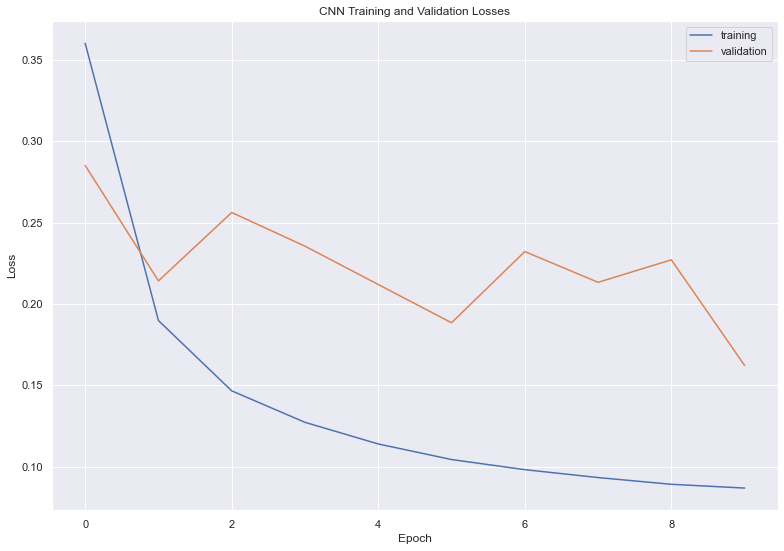

In [69]:
import matplotlib.pyplot as plt

plt.plot(fit_history.history["loss"], label="training")
plt.plot(fit_history.history["val_loss"], label="validation")
plt.title("CNN Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(figures_dir / f"cnn_{cnn_model_suffix}_loss.png")
plt.show()

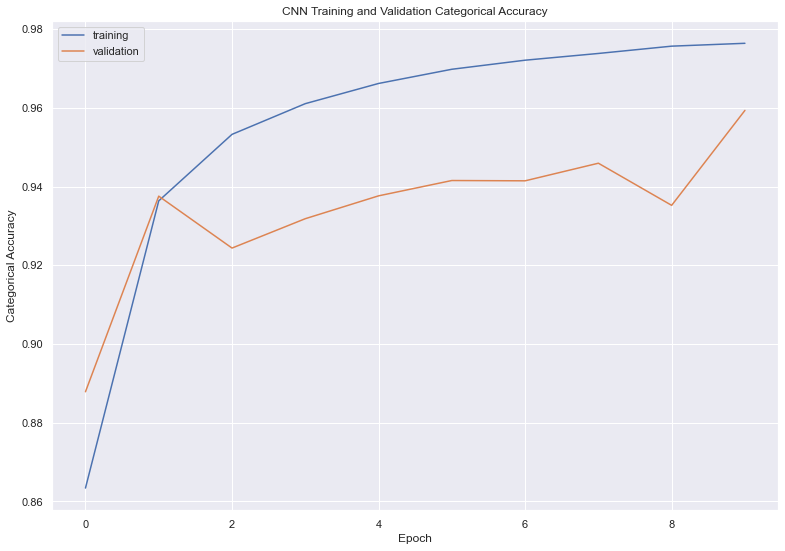

In [71]:
import matplotlib.pyplot as plt

plt.plot(fit_history.history["categorical_accuracy"], label="training")
plt.plot(fit_history.history["val_categorical_accuracy"], label="validation")
plt.title("CNN Training and Validation Categorical Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
plt.legend()
plt.savefig(figures_dir / f"cnn_{cnn_model_suffix}_cat_accuracy.png")
plt.show()

In [73]:
model.save(str(feature_extractor_model_file))

del model

INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/feature_extractor.tf/assets


In [5]:
from tensorflow.keras.models import load_model

loaded_model = load_model(str(feature_extractor_model_file))

loaded_model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 128, 128, 6)       168       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 64, 64, 12)        660       
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 32, 32, 24)        2616      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 16, 16, 24)   

In [125]:
valid_generator2 = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=(512, 512))

Found 39828 validated image filenames belonging to 3 classes.


# Evaluation / Confusion matrix

In [182]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [176]:
import numpy as np
import itertools

sns.set_style("whitegrid", {'axes.grid' : False})

# based on answer from https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          save_to=None,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize' : 26})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt_pct = lambda pct: f"{100 * pct:.2f}%" if normalize else f"{int(100 * pct)}%"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt_pct(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontdict={'fontsize' : 16})

    plt.ylabel('True label', fontdict={'fontsize' : 22})
    plt.xlabel('Predicted label', fontdict={'fontsize' : 22})
    plt.tight_layout()
    
    if save_to:
        plt.savefig(save_to)

In [126]:
raw_val_preds = loaded_model.predict(valid_generator2, steps=STEP_SIZE_VALID + 1, verbose=1)
raw_val_preds.shape

1245/1245 [==============================] - 275s 221ms/step


(39828, 3)

In [172]:
raw_val_preds[:5]

array([[1.0000000e+00, 4.6959087e-08, 1.7427676e-09],
       [9.9999750e-01, 2.4651283e-06, 5.0274412e-08],
       [1.0000000e+00, 2.6076517e-08, 4.6189781e-09],
       [9.9999988e-01, 1.0323813e-07, 4.3748369e-09],
       [9.9990737e-01, 9.2562856e-05, 1.6381273e-08]], dtype=float32)

In [173]:
val_preds = raw_val_preds.argmax(axis=1)
val_preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [130]:
valid_generator2.class_indices

{'CP': 0, 'NCP': 1, 'Normal': 2}

In [133]:
val_true = valid_generator2.labels

In [175]:
val_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [135]:
val_cm = confusion_matrix(val_true, val_preds)

In [188]:
class_labels = [k for k in valid_generator2.class_indices.keys()]

Normalized confusion matrix
[[0.95734597 0.00264664 0.04000739]
 [0.0134202  0.98006515 0.00651466]
 [0.05467136 0.02065363 0.92467501]]


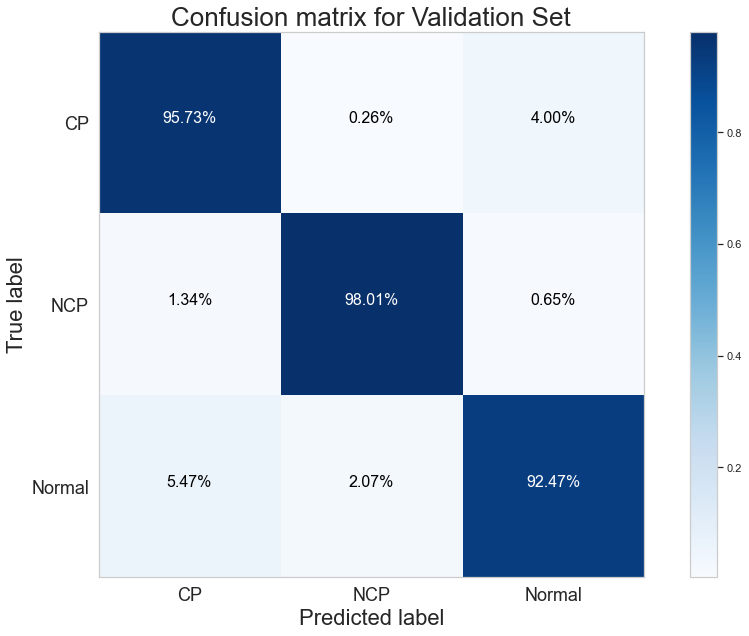

In [189]:
plot_confusion_matrix(
    val_cm,
    classes=class_labels,
    title='Confusion matrix for Validation Set',
    save_to=figures_dir / f"feature_generator_val_conf_matrix.png")

In [198]:
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_true, val_preds, average="weighted")
print(f"Validation F1 Score: {100 * val_f1: .2f}")
print(f"Validation Precision: {100 * val_precision: .2f}")
print(f"Validation Recall: {100 * val_recall: .2f}")

Validation F1 Score:  95.94
Validation Precision:  95.96
Validation Recall:  95.94


#### precision_recall_fscore_support(val_true, val_preds)

In [180]:
train_generator2 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=(512, 512))

Found 331286 validated image filenames belonging to 3 classes.


In [181]:
raw_train_preds = loaded_model.predict(train_generator2, steps=STEP_SIZE_TRAIN + 1, verbose=1)
raw_train_preds.shape

10353/10353 [==============================] - 3551s 343ms/step


(331286, 3)

In [183]:
train_preds = raw_train_preds.argmax(axis=1)
train_preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [184]:
train_generator2.class_indices

{'CP': 0, 'NCP': 1, 'Normal': 2}

In [185]:
train_true = train_generator2.labels
train_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Normalized confusion matrix
[[0.99460001 0.0014921  0.00390788]
 [0.00390522 0.98839638 0.0076984 ]
 [0.01667127 0.01844134 0.96488739]]


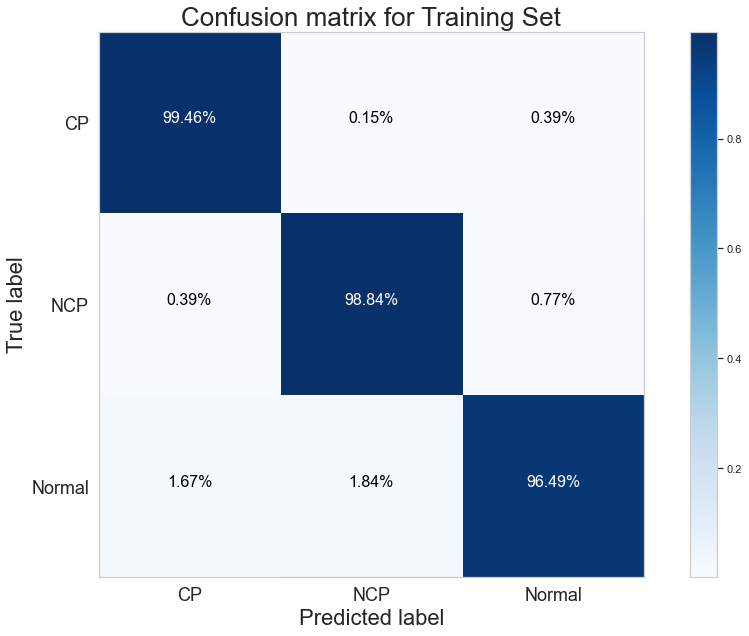

In [186]:
train_cm = confusion_matrix(train_true, train_preds)
plot_confusion_matrix(
    train_cm,
    classes=[k for k in train_generator2.class_indices.keys()],
    title='Confusion matrix for Training Set',
    save_to=figures_dir / f"feature_generator_train_conf_matrix.png")

In [195]:
precision_recall_fscore_support(train_true, train_preds)

(array([0.98579019, 0.98675391, 0.98139636]),
 array([0.99460001, 0.98839638, 0.96488739]),
 array([0.9901755 , 0.98757446, 0.97307186]),
 array([126667, 124961,  79658]))

In [196]:
precision_recall_fscore_support(train_true, train_preds, average="macro")

(0.9846468177677424, 0.9826279291628729, 0.9836072750264194, None)

## Evaluate test set

In [200]:
test_df = repo.load("test_df")

In [201]:
test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=(512, 512))

Found 40415 validated image filenames belonging to 3 classes.


1263/1263 [==============================] - 448s 355ms/step
Normalized confusion matrix
[[0.96026924 0.01143674 0.02829402]
 [0.01535533 0.9606599  0.02398477]
 [0.02567688 0.03800686 0.93631626]]


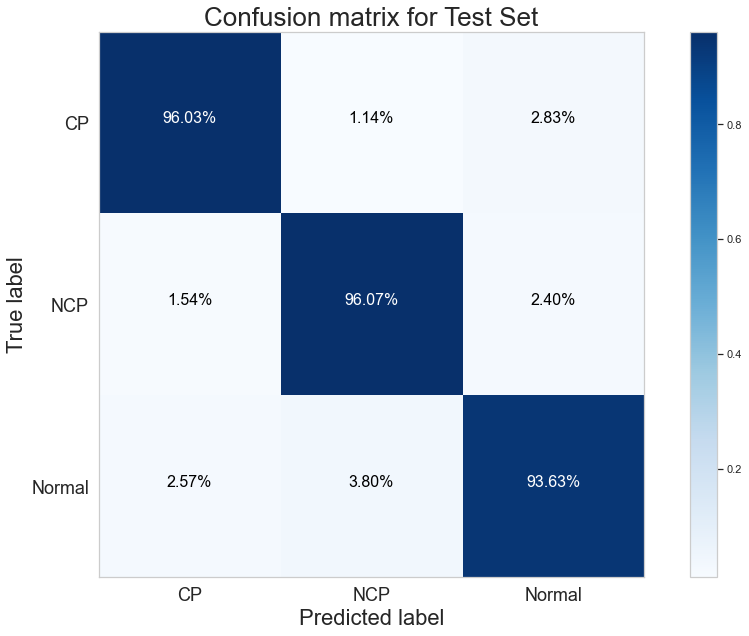

In [203]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

raw_test_preds = loaded_model.predict(test_generator, steps=STEP_SIZE_TEST + 1, verbose=1)
raw_test_preds.shape
test_preds = raw_test_preds.argmax(axis=1)
test_preds[:10]
test_generator.class_indices
test_true = test_generator.labels
test_true[:10]
test_cm = confusion_matrix(test_true, test_preds)
plot_confusion_matrix(
    test_cm,
    classes=[k for k in test_generator.class_indices.keys()],
    title='Confusion matrix for Test Set',
    save_to=figures_dir / f"feature_generator_test_conf_matrix.png")

In [204]:
precision_recall_fscore_support(test_true, test_preds)

(array([0.9731965 , 0.96858806, 0.89621608]),
 array([0.96026924, 0.9606599 , 0.93631626]),
 array([0.96668965, 0.96460769, 0.91582743]),
 array([16788, 15760,  7867]))

In [205]:
precision_recall_fscore_support(test_true, test_preds, average="macro")

(0.9460002151692235, 0.9524151320653768, 0.9490415902612338, None)

# Saliency map

In [50]:
from tensorflow.keras.models import load_model
model_path = Path("/home/albert/projects/tfg/models/cnn_04")
import matplotlib.pyplot as plt

In [31]:
!ls {model_path}/checkpoint

assets	saved_model.pb	variables


In [36]:
model = load_model(str(model_path / "checkpoint"))

model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 512, 512, 8)       224       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 256, 256, 16)      1168      
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 64, 64, 32)   

In [23]:
import numpy as np
import tensorflow as tf

In [9]:
from keras_preprocessing.image import ImageDataGenerator

seed = config.get_int("tfg.seed")
val_fraction = config.get_float("tfg.training.val_fraction")
saliency_datagen = ImageDataGenerator(rescale=1./255.)
batch_size = config.get_int("tfg.training.batch_size")

test_df = repo.load("test_df")
saliency_generator = saliency_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=(512, 512))

Found 40415 validated image filenames belonging to 3 classes.


In [10]:
ns = saliency_generator.next()

In [46]:
from tfg.utils.saliency import plot_saliency_from_img_arr

In [66]:
from tfg.utils.integrated_gradients import plot_img_attributions

In [19]:
num_test_images = ns[1].shape[0]

In [21]:
class_to_idx = saliency_generator.class_indices
idx_to_class = { v: k for k, v in class_to_idx.items()}

In [25]:
model = loaded_model

In [28]:
ns[0][i].shape

(512, 512, 3)

In [37]:
i = 0
target_class_idx = np.argmax(ns[1][i])
true_label = idx_to_class[target_class_idx]
img = ns[0][i]
img = ns[0][i].reshape((1, *img.shape))
preds = model.predict(img)
pred_label = idx_to_class[np.argmax(preds)]

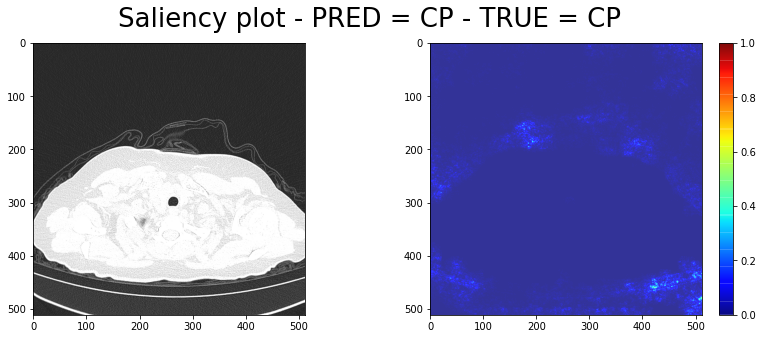

(<Figure size 1008x360 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [47]:
plot_saliency_from_img_arr(model, ns[0][i], true_label, pred_label)

In [67]:
plot_img_attributions(model, ns[0][i], target_class_idx, true_label, pred_label, m_steps=240,
                              cmap=plt.cm.inferno,
                              overlay_alpha=0.4)

Tensor("zeros:0", shape=(512, 512, 3), dtype=float32)
Tensor("image:0", shape=(512, 512, 3), dtype=float32)


ResourceExhaustedError:  OOM when allocating tensor with shape[32,16,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node while/body/_1/covid_classifier/conv2d_02/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_integrated_gradients_9454]

Function call stack:
integrated_gradients


In [59]:
model.layers[0].input_shape[0][1:]

(512, 512, 3)

In [60]:
model.layers[0].input_shape[0][1:]
img_arr = ns[0][i]
image = img_arr.reshape((1, *img_arr.shape))

In [61]:
image.shape

(1, 512, 512, 3)

In [ ]:
plot_saliency_from_img_arr(model, ns[0][i], true_label, pred_label)

In [12]:
# ns[0][0]

array([[[0.14901961, 0.14901961, 0.14901961],
        [0.16078432, 0.16078432, 0.16078432],
        [0.18431373, 0.18431373, 0.18431373],
        ...,
        [0.18431373, 0.18431373, 0.18431373],
        [0.21568629, 0.21568629, 0.21568629],
        [0.14901961, 0.14901961, 0.14901961]],

       [[0.20392159, 0.20392159, 0.20392159],
        [0.15294118, 0.15294118, 0.15294118],
        [0.14901961, 0.14901961, 0.14901961],
        ...,
        [0.19607845, 0.19607845, 0.19607845],
        [0.15294118, 0.15294118, 0.15294118],
        [0.15294118, 0.15294118, 0.15294118]],

       [[0.15686275, 0.15686275, 0.15686275],
        [0.1764706 , 0.1764706 , 0.1764706 ],
        [0.14901961, 0.14901961, 0.14901961],
        ...,
        [0.16862746, 0.16862746, 0.16862746],
        [0.1764706 , 0.1764706 , 0.1764706 ],
        [0.20000002, 0.20000002, 0.20000002]],

       ...,

       [[0.27058825, 0.27058825, 0.27058825],
        [0.21176472, 0.21176472, 0.21176472],
        [0.14901961, 0

In [222]:
cp_img_file = f"{data_dir}/compare/CP.png"
ncp_img_file = f"{data_dir}/compare/NCP.png"
normal_img_file = f"{data_dir}/compare/Normal.png"

In [251]:
model = load_model(str(feature_extractor_model_file))

In [273]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


def plot_saliency(model, img_file, label):
    _img = keras.preprocessing.image.load_img(img_file, target_size=(512, 512))
    img = keras.preprocessing.image.img_to_array(_img)
    img = img.reshape((1, *img.shape))
    y_pred = model.predict(img)
    """
    The highest class score is at index 0, which is equivalent to the CP class.
    We can calculate the gradient with respect to the top class score to see
    which pixels in the image contribute the most:
    """
    images = tf.Variable(img, dtype=float)

    with tf.GradientTape() as tape:
        pred = model(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)
    dgrad_abs = tf.math.abs(grads)
    dgrad_max = np.max(dgrad_abs, axis=3)[0]
    ## normalize to range between 0 and 1
    arr_min, arr_max  = np.min(dgrad_max), np.max(dgrad_max)
    grad_eval = (dgrad_max - arr_min) / (arr_max - arr_min + 1e-18)
    
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    fig.suptitle(f"Saliency plot - class = {label}", fontsize=26)

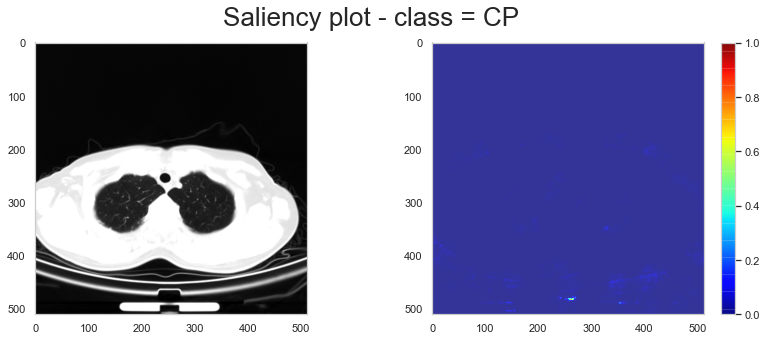

In [274]:
plot_saliency(model, cp_img_file, "CP")

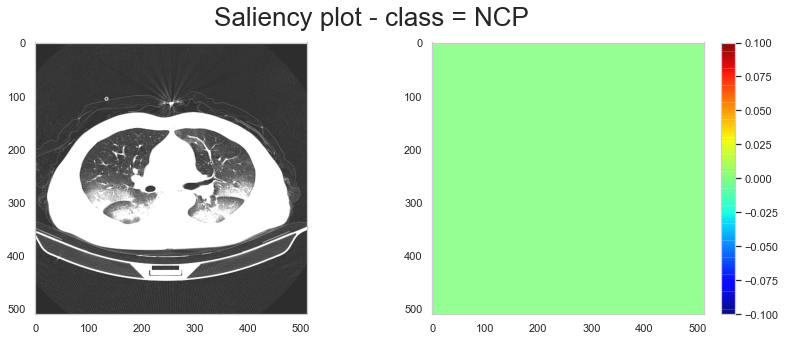

In [275]:
plot_saliency(model, ncp_img_file, "NCP")

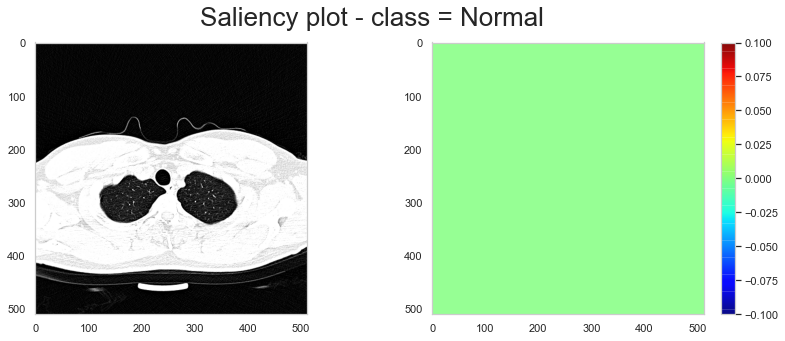

In [276]:
plot_saliency(model, normal_img_file, "Normal")